# Translation Agent

In [1]:
import os
import src.translation_agent as ta



In [2]:
# quick test
source_text="Hello, world!"
source_lang, target_lang, country = "English", "Chinese", "China"
translation = ta.translate(source_lang, target_lang, source_text, country)
print(translation)

ic| num_tokens_in_text: 4
ic| 'Translating text as single chunk'


嗨，世界！


In [4]:
source_lang, target_lang, country = "English", "Chinese", "China"

relative_path = "examples/sample-texts/sample-short1.txt"
relative_path = "examples/sample-texts/sample-long1.txt"
script_dir = os.getcwd()

full_path = os.path.join(script_dir, relative_path)

with open(full_path, encoding="utf-8") as file:
    source_text = file.read()

print(f"Source text:\n\n{source_text}\n------------\n")

translation = ta.translate(
    source_lang=source_lang,
    target_lang=target_lang,
    source_text=source_text,
    country=country,
)

print(f"Translation:\n\n{translation}")

ic| num_tokens_in_text: 672
ic| 'Translating text as single chunk'


Source text:

Last week, I spoke about AI and regulation at the U.S. Capitol at an event that was attended by legislative and business leaders. I’m encouraged by the progress the open source community has made fending off regulations that would have stifled innovation. But opponents of open source are continuing to shift their arguments, with the latest worries centering on open source's impact on national security. I hope we’ll all keep protecting open source!

Based on my conversations with legislators, I’m encouraged by the progress the U.S. federal government has made getting a realistic grasp of AI’s risks. To be clear, guardrails are needed. But they should be applied to AI applications, not to general-purpose AI technology.

Nonetheless, as I wrote previously, some companies are eager to limit open source, possibly to protect the value of massive investments they’ve made in proprietary models and to deter competitors. It has been fascinating to watch their arguments change over 

In [2]:
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util
# 计算METEOR分数和BLEU分数
def calculate_metrics(reference, candidate):
    # 预先分词
    reference_tokens = nltk.word_tokenize(reference)
    candidate_tokens = nltk.word_tokenize(candidate)
    # 计算METEOR分数
    score_m = meteor_score([reference_tokens], candidate_tokens)
    # 使用 SmoothingFunction 来避免得分为 0 的情况
    smooth = SmoothingFunction().method1
    # 计算句子级别的BLEU分数
    sentence_bleu_score = sentence_bleu(reference, candidate_tokens, smoothing_function=smooth)
    return score_m, sentence_bleu_score

# Sentence-BERT模型的指标计算
def calculate_metrics_sbert(reference, candidate, sbert_model):
    # 生成嵌入向量
    reference_embedding = sbert_model.encode(reference, convert_to_tensor=True)
    candidate_embedding = sbert_model.encode(candidate, convert_to_tensor=True)
    # 计算余弦相似度
    cosine_similarity = util.pytorch_cos_sim(reference_embedding, candidate_embedding)
    return cosine_similarity.item()

/root/miniconda3/envs/llm-universe/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
import pandas as pd
# 加载预训练的 Sentence-BERT 模型
sbert_model = SentenceTransformer("/root/translation/model")
# 使用pandas读取CSV文件
df = pd.read_csv('./tests/result_trans_S2.csv', encoding='utf-8')
query_list = df['query'].tolist()
for i in range(len(query_list)):
    query = query_list[i]
    # 计算METEOR分数和BLEU分数-Benchmark
    #b_m, b_b = calculate_metrics(df['expert'][i], df['alibaba'][i])
    #df.loc[i, 'Benchmark-B'] = b_b
    #df.loc[i, 'Benchmark-M'] = b_m
    # 计算Sentence-BERT分数-Benchmark
    #b_s = calculate_metrics_sbert(df['expert'][i], df['alibaba'][i], sbert_model)
    #df.loc[i, 'Benchmark-S'] = b_s
    s2_s_1 = calculate_metrics_sbert(df['expert'][i], df['answer'][i], sbert_model)
    df.loc[i, 'S2-S-1'] = s2_s_1
    if str(df['intermediate'][i]) != 'nan':
        s2_s_2 = calculate_metrics_sbert(df['expert'][i], df['intermediate'][i], sbert_model)
        df.loc[i, 'S2-S-2'] = s2_s_2

# df结果另存为文件
df.to_csv('./tests/result_trans_S2.csv', index=False, encoding='utf-8', mode='w')

No sentence-transformers model found with name /root/translation/model. Creating a new one with mean pooling.


count    233.000000
mean       0.671153
std        0.188762
min        0.135135
25%        0.564557
50%        0.672222
75%        0.808607
max        0.999878
Name: Benchmark-M, dtype: float64
0.6722222222222223


<Axes: >

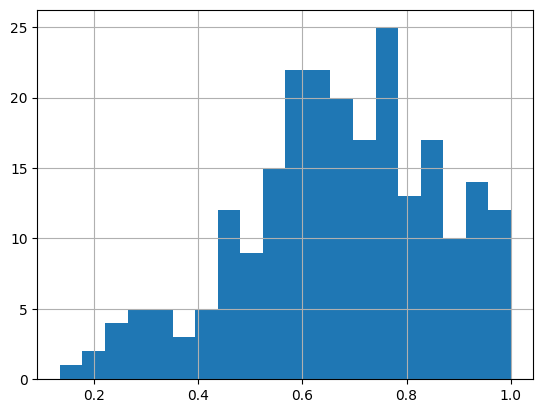

In [8]:
import pandas as pd
df = pd.read_csv('./tests/result_trans.csv', encoding='utf-8')
# 对df中的Benchmark-M列进行数据统计，统计平均值，标准差，最小值，最大值
print(df['Benchmark-M'].describe())
# 给出中位数，四分位数，百分位数
print(df['Benchmark-M'].median())
# 画出Benchmark-M列的直方图
df['Benchmark-M'].hist(bins=20)